## ECS7013P Lab 1: Introduction

The goal of this lab is to construct a simple "linear regression" network to detect bird call activities in an audio file. Via this lab, you will learn about processing audio files, building a network with Pytorch, training the network with labeled data and evaluating it, and data visualization. Students are expected to be already familiar with the linear regression method.

In [2]:
# Import the packages we'll use

import numpy as np
import os, glob, csv

# librosa is a widely-used audio processing library
import librosa

#sklearn is a useful toolkit for machine learning
import sklearn

#pytorch: deep learning framework
import torch
import torch.nn as nn
import torch.nn.functional as nnF

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt

# for accessing the dataset
import boto3

# for loading audiofiles from the dataset
import soundfile as sf
import io

Datasets are now stored in aws bucket hosted within QM: `data-repository-bkt`. We can access and read data from the dataset using AWS and boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/index.html. To access the bucket we need an aws access key id and an aws secret access key. For this module these are:
- AWS_ACCESS_KEY_ID= H9DY76USDY1A96F8G7KZ
- AWS_SECRET_ACCESS_KEY= I5Abn9dsyPH6qXoTxOkMXSgZ0paBB9yRBPD1A4uX

We also need to know the endpoint url for QM's bucket: `https://eph-object-rgw.comp-teach.qmul.ac.uk`


In [3]:
# Keys for aws dataset access
# note: same keys for everyone
aws_access_key_id = 'H9DY76USDY1A96F8G7KZ'
aws_secret_access_key = 'I5Abn9dsyPH6qXoTxOkMXSgZ0paBB9yRBPD1A4uX'

# Aws Bucket specifics
bucketname = 'data-repository-bkt'
coursecode = 'ECS7013P'
dataset = 'warblrb10k'

# setup the bucket access:
qmul_bucket_resource = boto3.resource('s3',endpoint_url='https://ceph-object-rgw.comp-teach.qmul.ac.uk',
                                    aws_access_key_id=aws_access_key_id,
                                    aws_secret_access_key=aws_secret_access_key)

# we will using qmul_bucket_resource to read the dataset metadata and audio file data from the dataset

In [4]:
# Get the warblrb10k_public_metadata_2018.csv from the bucket.
# This is obtained as a byte stream so needs to be decoded and then processed as a csv file.
warblrb10k_csv_byte_stream = qmul_bucket_resource.Object(bucketname, 
                                                         f'{coursecode}/{dataset}/warblrb10k_public_metadata_2018.csv').get()

# here we load the metadata labels
binarylabels = {}

#maxfilestoload  = 50      # limit, because loading the whole dataset is very slow

# decode the byte stream and create a csv reader:
warblrb10k_csv_rdr = csv.reader(line.decode() for line in warblrb10k_csv_byte_stream['Body'].iter_lines())

# Process each lines of warblrb10k_csv_rdr and add map the
# label (hasbird) to the corresponding audio file name
for row in warblrb10k_csv_rdr:
    
        # What will the first row of a csv file usually contain?
        # Complete this line to process the csv header:
        # if ... in row:
        #     continue
        if 'hasbird' in row:
            continue

        # complete the line below to read the map the label (hasbird) to the corresponding audio file name
        # binarylabels[row[...]] = float(row[...])
        binarylabels[row[0]] = float(row[2])

        #if len(binarylabels)==maxfilestoload:
        #        break  # note, here we are restricting the maximum number of rows.
    
fkeys = sorted(binarylabels.keys())
# inspect:
for i, kv in enumerate(binarylabels.items()):
    print(kv)
    if i==10: break

('759808e5-f824-401e-9058', 1.0)
('1d94fc4a-1c63-4da0-9cac', 1.0)
('bb0099ce-3073-4613-8557', 1.0)
('c4c67e81-9aa8-4af4-8eb7', 1.0)
('ab322d4b-da69-4b06-a065', 0.0)
('519cfbe6-f804-4add-baa3', 0.0)
('6332d960-6f57-4ecc-8d1a', 1.0)
('db89b696-5ca0-4ca8-982a', 1.0)
('a02ac7bc-5a29-40a1-89e1', 1.0)
('6ce66c37-3a83-43b1-b0dd', 1.0)
('126160c6-cd85-41f7-a5e7', 1.0)


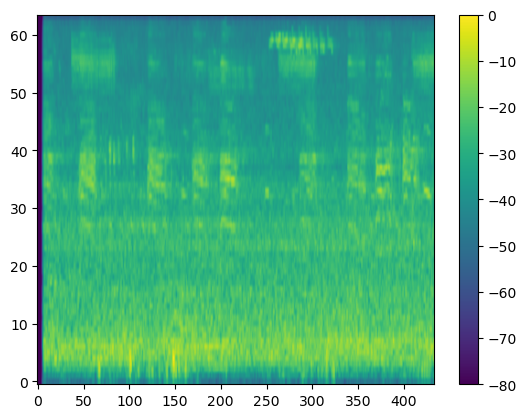

In [5]:
# load an example audio file, converting the data to mel spectrogram
examplefkey = '1d94fc4a-1c63-4da0-9cac'

# get the audio file from te bucket using
wav_byte_stream = qmul_bucket_resource.Object(bucketname, f'{coursecode}/{dataset}/wav/{examplefkey}.wav').get()

# then we need to convert the wav_byte_stream into audio data 
# we do this be converting the stream using io.BytesIO
# then using soundfile (imported as sf) to convert 
# the io.BytesIO into audio data.

example_audio, sr = sf.read(io.BytesIO(wav_byte_stream['Body'].read()))

# We need to resample the audio as the byte stream reads in the audio at a sampling rate of 44100
# however the original dataset sample rate is 22100, and the annotations are aligned to this sampling frequency.
example_audio = librosa.resample(y=example_audio, orig_sr=sr, target_sr=22100) # note the sampling frequency 
sr = 22100
example = librosa.feature.melspectrogram(y=example_audio, sr=sr, n_mels=64) # note the number of mel bands

# player
import IPython.display as ipd
audio_element_url = ipd.Audio(example_audio, rate=sr)
ipd.display(audio_element_url)


# Let's look at the spectrogram of one example
plt.imshow(librosa.power_to_db(example, ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

In [6]:
print(example.shape)

(64, 434)


Let's annotate this audio clip in detail, specifying for each *frame* whether it has any bird call active or not.

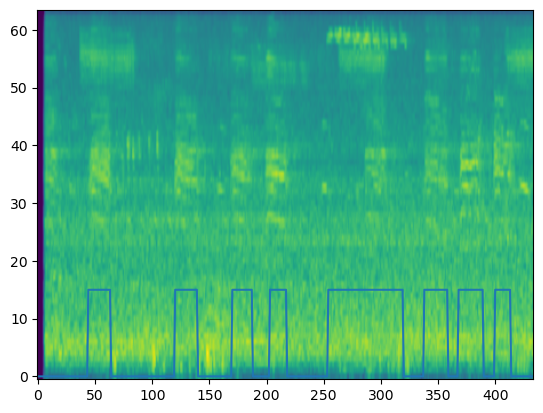

In [7]:
annotation = np.zeros(434)
for onset, offset in [
    (44, 64),
    (120, 140),
    (170, 188),
    (203, 218),
    (254, 320),
    (338, 359),
    (368, 390),
    (400, 414),
                     ]:
    annotation[onset:offset] = 1
    
plt.imshow(librosa.power_to_db(example, ref=np.max), aspect='auto', origin='lower')
plt.plot(annotation*15)

Next we want to establish if there is any *linear* relationship between the energy in the frequency bands, and the regressor (the "independent variable") which is our annotation.

Mean energy when activity is 0: 0.452
Mean energy when activity is 1: 0.859462


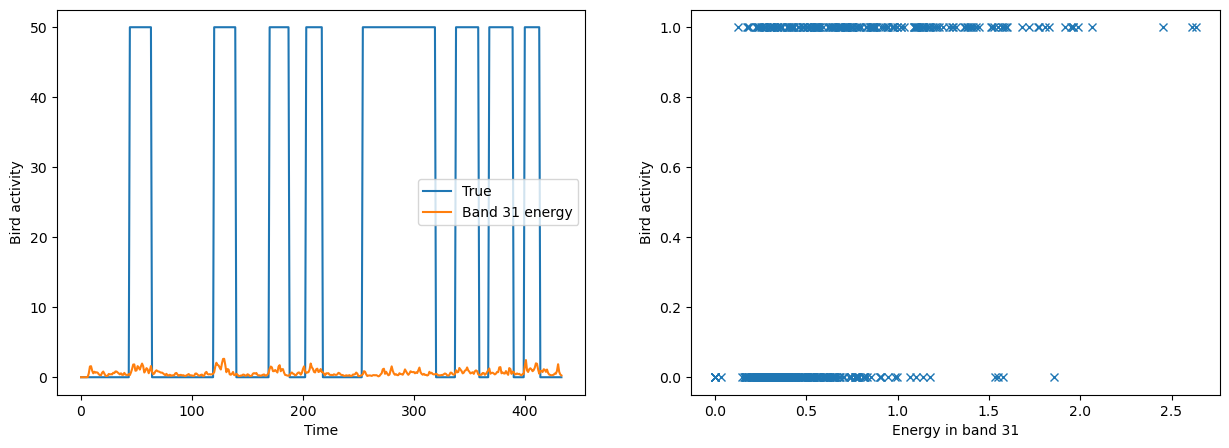

In [8]:
# As a simple example, here's a scatter plot of the energy in frequency band index "31" and our annotation.
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[1].plot(example[31,:], annotation, 'x')
ax[1].set_xlabel("Energy in band 31")
ax[1].set_ylabel("Bird activity")

ax[0].plot(annotation * 50, label="True")
ax[0].plot(example[31,:], label="Band 31 energy")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Bird activity")
ax[0].legend()


print("Mean energy when activity is 0: %g" % np.mean(example[31, np.nonzero(annotation==0)]))
print("Mean energy when activity is 1: %g" % np.mean(example[31, np.nonzero(annotation==1)]))

In [19]:
# Let's set this problem up within the Torch framework:
def sigmoid(x):
    "Applies a sigmoid nonlinearity to a numpy vector of values"
    # complete this function hint: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
    sm = nn.Sigmoid()(x) # or implement the maths.
    return sm

class LinearRegress(nn.Module):
    def __init__(self, nfreqs):
        super(LinearRegress, self).__init__()
        # initialize the parameters with random values
        self.beta = nn.Parameter(torch.randn((nfreqs,1)).abs() * 1e-4)
        self.offset = nn.Parameter(torch.rand((nfreqs,1)) * 1e-4)
        # question: what is the difference between "torch.randn" and "torch.rand"?

    def forward(self, x):
        "Project the data through the coefficients"
        # complete this function
        # hint: think about the linear regression equation from the lecture
        # you might want to use: https://pytorch.org/docs/stable/generated/torch.sum.html
        y = torch.sum(x * self.beta + self.offset, dim=0)
        
        # uncomment the following line to covert to a logisitc regression model:
        #y = sigmoid((torch.sum(x * self.beta + self.offset, dim=0)))
        
        return y
    
    def forward_and_convert(self, x):
        "Handles the torch<--->numpy tensor conversion, for convenience"
        x_torch = torch.DoubleTensor(x)
        y_torch = self.forward(x_torch)
        return y_torch.detach().numpy()

Text(0.5, 1.0, 'Linear regression as bird detector - BEFORE fitting')

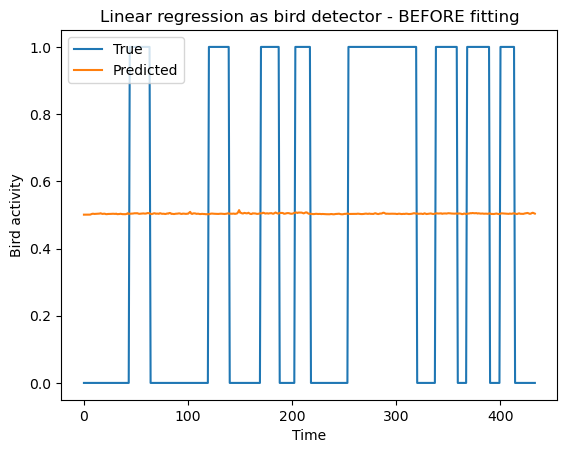

In [23]:
# create a LinearRegress network instance
net = LinearRegress(64)
# our network is currently RANDOMLY initialised. What happens when we project our audio through it?
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Linear regression as bird detector - BEFORE fitting")

In [24]:
# define a loss function and an optimiser
# which loss function should we use for this problem, compelte the line below
criterion = nn.MSELoss()   # hint what is the loss called?
optimizer = torch.optim.SGD(net.parameters(), lr=0.0000001, momentum=0.8) # optimizer

In [25]:
#annotation

In [26]:
# train the network
num_epochs = 10000 # number of training epochs
annot_torch = torch.DoubleTensor(annotation)
for epoch in range(num_epochs):

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # complete the lines below
    #outputs = ... # forward pass
    #loss = ... # loss
    #... # backward pass
    
    outputs = net(torch.DoubleTensor(example))
    loss = criterion(annot_torch, outputs)
    loss.backward()
    
    optimizer.step()

    running_loss = loss.item()
    if ((epoch & (epoch - 1)) == 0) or epoch==(num_epochs-1): # don't print on all epochs
        # print statistics
        print('[%d] loss: %.8f' %
            (epoch, running_loss))

example_result = outputs.detach().numpy()
print('Finished Training')

[0] loss: 0.25012549
[1] loss: 0.25012518
[2] loss: 0.25012461
[4] loss: 0.25012292
[8] loss: 0.25011817
[16] loss: 0.25010652
[32] loss: 0.25008168
[64] loss: 0.25003183
[128] loss: 0.24993281
[256] loss: 0.24973751
[512] loss: 0.24935773
[1024] loss: 0.24864024
[2048] loss: 0.24735829
[4096] loss: 0.24526328
[8192] loss: 0.24211130
[9999] loss: 0.24095005
Finished Training


Text(0.5, 1.0, 'Linear regression as bird detector')

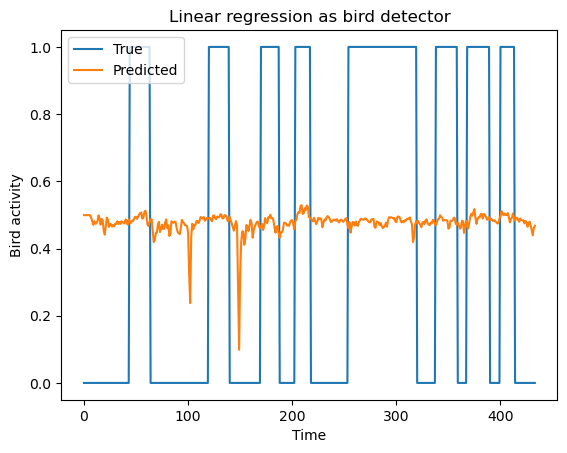

In [27]:
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Linear regression as bird detector")

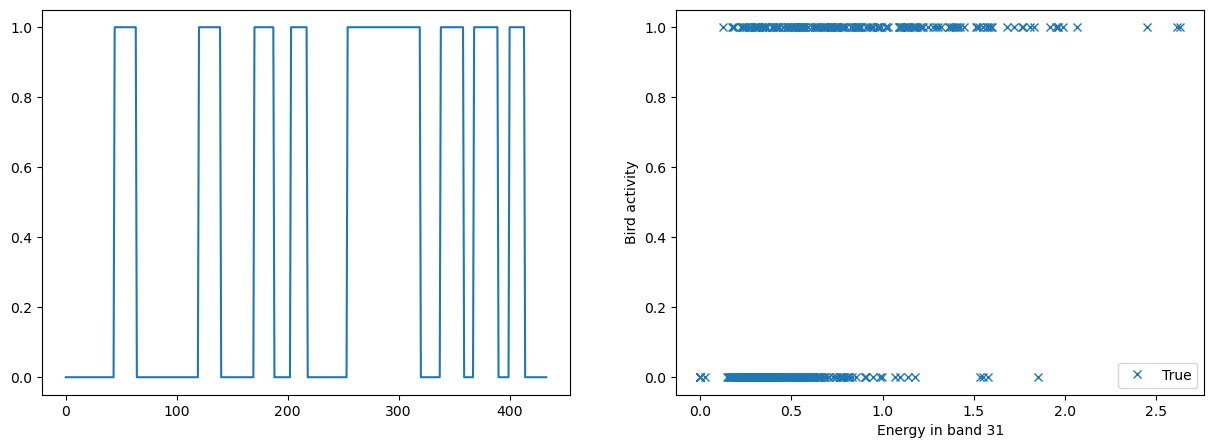

In [28]:
### Let's compare the linear regression predictions against our "energy in band 31" scatter
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(annotation, label="True")
ax[1].plot(example[31,:], annotation, 'x', label="True")

### This code makes a prediction with band 31 only
### (replacing other bands with their average energy, to keep them fixed)
if False:
    # Question: can you explain what the line below does?
    example_reduced = np.repeat(np.mean(example, axis=1, keepdims=True), repeats=example.shape[1], axis=1)
    example_reduced[31,:] = example[31,:]
    ax[0].plot(net.forward_and_convert(example_reduced), label="Predicted (31 only)")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Bird activity")
    ax[0].legend()
    ax[1].plot(example[31,:], net.forward_and_convert(example_reduced), '.', label="Predicted (31 only)")

### This plots the "full" regression prediction from all data
if False:
    ax[0].plot(net.forward_and_convert(example), label="Predicted (full)")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Bird activity")
    ax[0].legend()
    ax[1].plot(example[31,:], net.forward_and_convert(example), '.', label="Predicted (full)")

ax[1].set_xlabel("Energy in band 31")
ax[1].set_ylabel("Bird activity")
ax[1].legend()

Text(0.5, 0, 'Frequency')

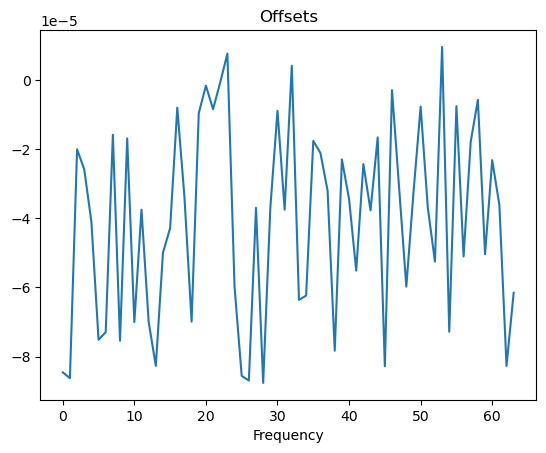

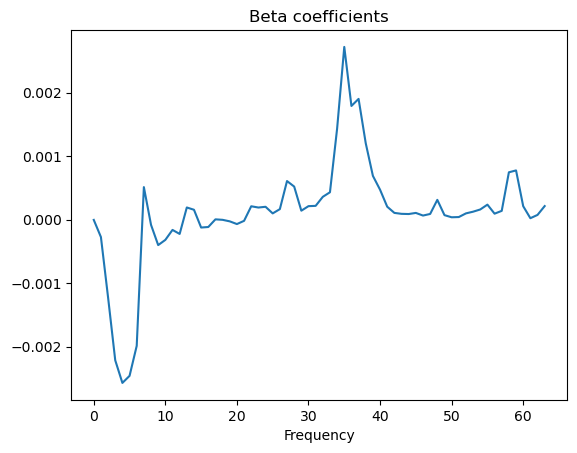

In [29]:
# Let's inspect the parameters
plt.figure()
plt.plot(net.offset.detach().numpy())
plt.title("Offsets")
plt.xlabel("Frequency")
plt.figure()
plt.plot(net.beta.detach().numpy())
plt.title("Beta coefficients")
plt.xlabel("Frequency")

Exercise
-------

* Convert this from a linear regression to a *logistic* regression. Retrain it and inspect how well it can do.
* Experiment with the optimiser options such as learning rate and momentum.